In [ ]:
### Importing Libraries ###

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import celltypist
from celltypist import models

In [ ]:
# Load the MuData Training object

mdata = muon.read('/home/training.h5mu')   

In [ ]:
# Gene list for model training

selected_genes = ["FANCA","NDC80","MYBL2", "E2F8", "TOP2A", "CDC6", "KIF15", "DEPDC1", "POLQ", "FEN1", "EME1", "TCF19", "EXO1", "RAD51", "DNMT3B", "DEPDC1B", "E2F7", "CENPS", "E2F1", "E2F2", "PCNA", "HMGB2", "BRCA1", "HMGB3", "FANCD2", "MXD3", "FOXM1", "PTTG1", "YEATS4", "ZNF367", "DNA2", "SUV39H1", "GEN1", "TONSL", "LIG1", "MAD2L2", "SIVA1", "DEK", "CARHSP1", "PHF19", "EZH2", "HMGA1", "BLM"]

In [ ]:
### Model Training ###
# Train CellTypist Model

#new_model = celltypist.train(mdata.mod['rna'], labels = 'LIC', n_jobs = 10, feature_selection=True)
new_model = celltypist.train(mdata.mod['selected_genes'], check_expression=False , labels = 'predicted_labels',use_SGD=True)

In [ ]:
# Run celltypist.annotate() function on the data without overclustering labels

predictions1 = celltypist.annotate(
    mdata.mod['rna'],
    model=new_model,
    majority_voting=True,
)

# Convert predictions to AnnData object

mdata.mod['rna'] = predictions1.to_adata()

🔬 Input data has 16674 cells and 1938 genes
🔗 Matching reference genes in the model
🧬 867 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


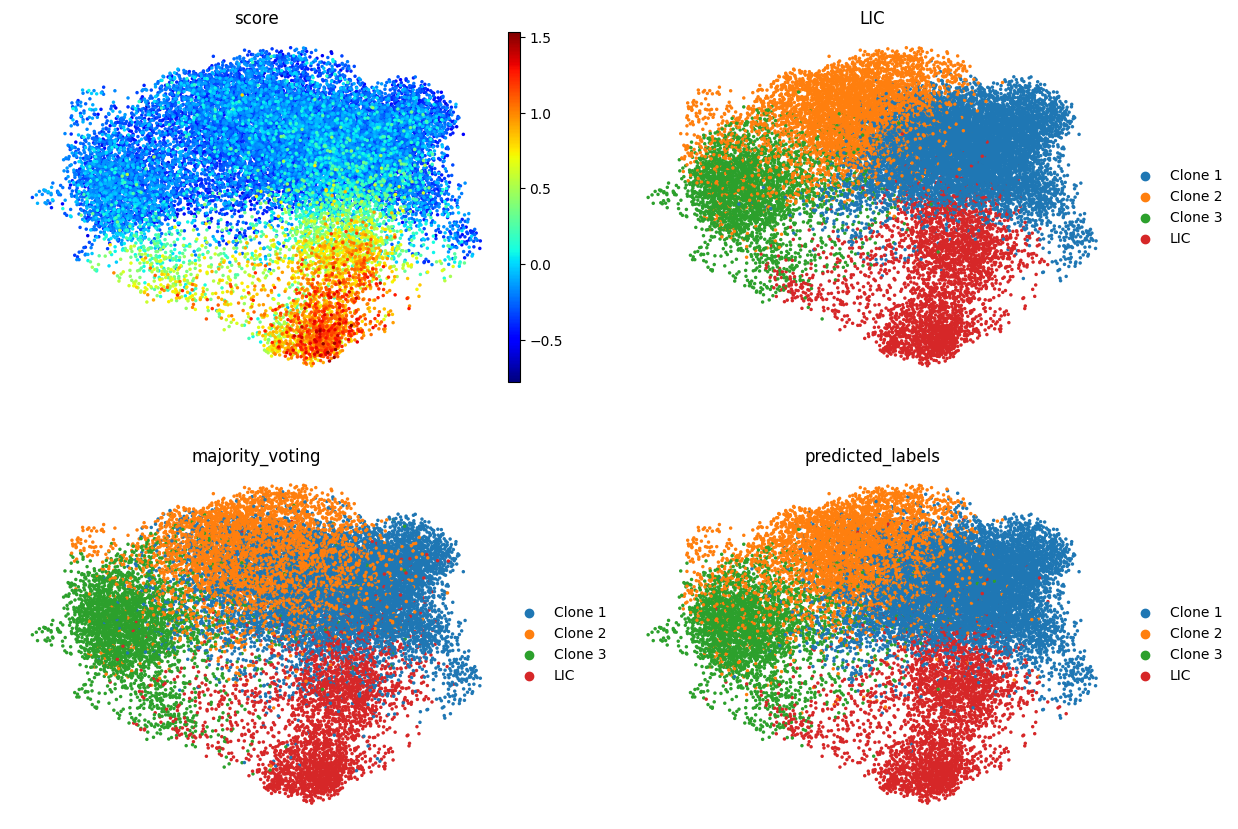

In [ ]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    mdata.mod['rna'],
    basis="draw_graph_fa",
    color=['score',"LIC", "majority_voting",'predicted_labels'],
    frameon=False,
    size=25,
    ncols=2,
    color_map='jet',
)

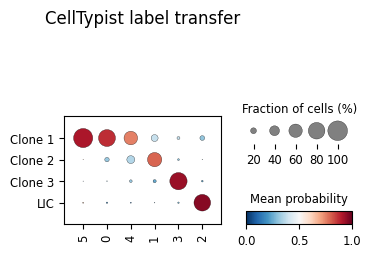

In [ ]:
# Dotplot of CellTypist predictions vs FA leiden_totalVI clusters

celltypist.dotplot(predictions1, use_as_reference = 'leiden_totalVI', use_as_prediction = 'majority_voting')

In [ ]:
# Run celltypist.annotate() function on the data with overclustering labels

predictions2 = celltypist.annotate(
    mdata.mod['rna'],
    model=new_model,
    majority_voting=True,
    over_clustering='leiden_totalVI'
)

# Convert predictions to AnnData object

mdata.mod['rna'] = predictions2.to_adata()

🔬 Input data has 16674 cells and 1938 genes
🔗 Matching reference genes in the model
🧬 867 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


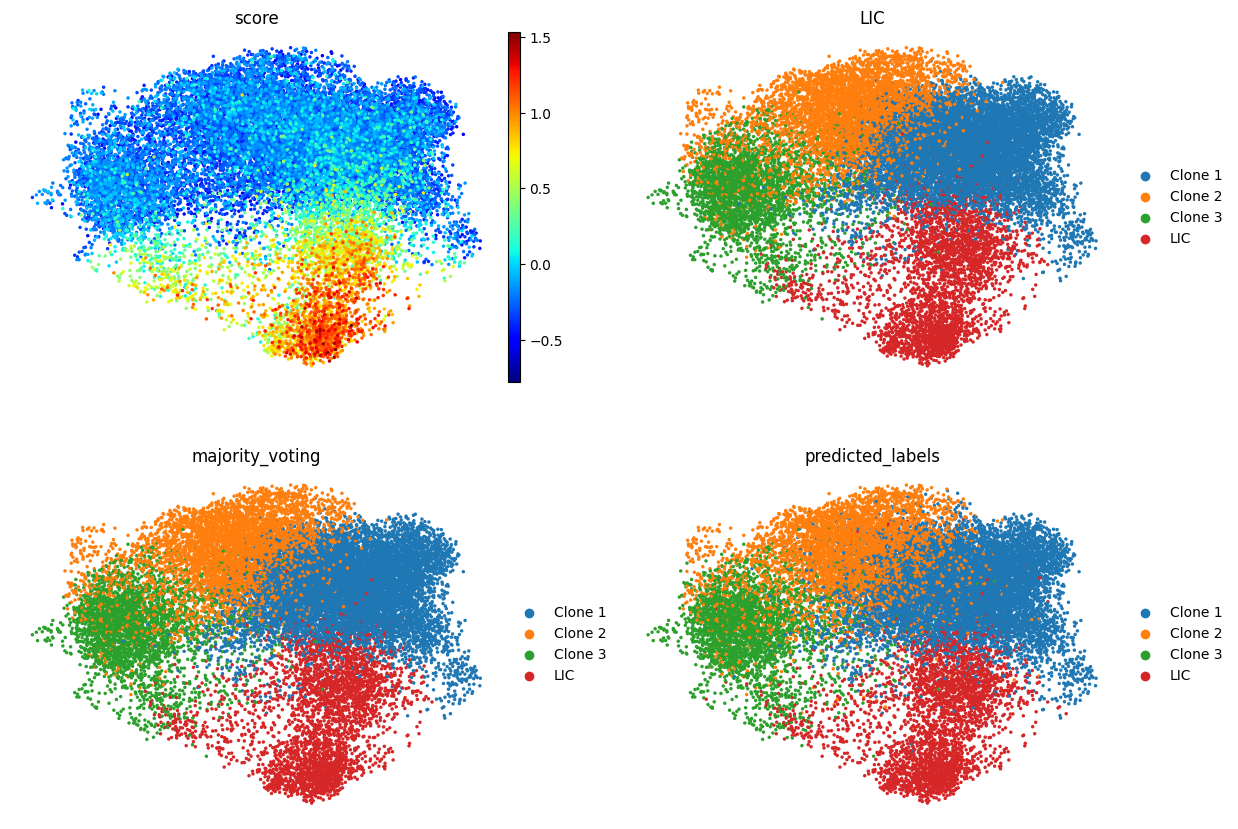

In [ ]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    mdata.mod['rna'],
    basis="draw_graph_fa",
    color=['score',"LIC", "majority_voting",'predicted_labels'],
    frameon=False,
    size=25,
    ncols=2,
    color_map='jet',
)

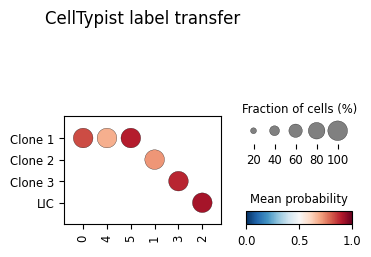

In [ ]:
# Dotplot of CellTypist predictions vs FA leiden_totalVI clusters

celltypist.dotplot(predictions2, use_as_reference = 'leiden_totalVI', use_as_prediction = 'majority_voting')

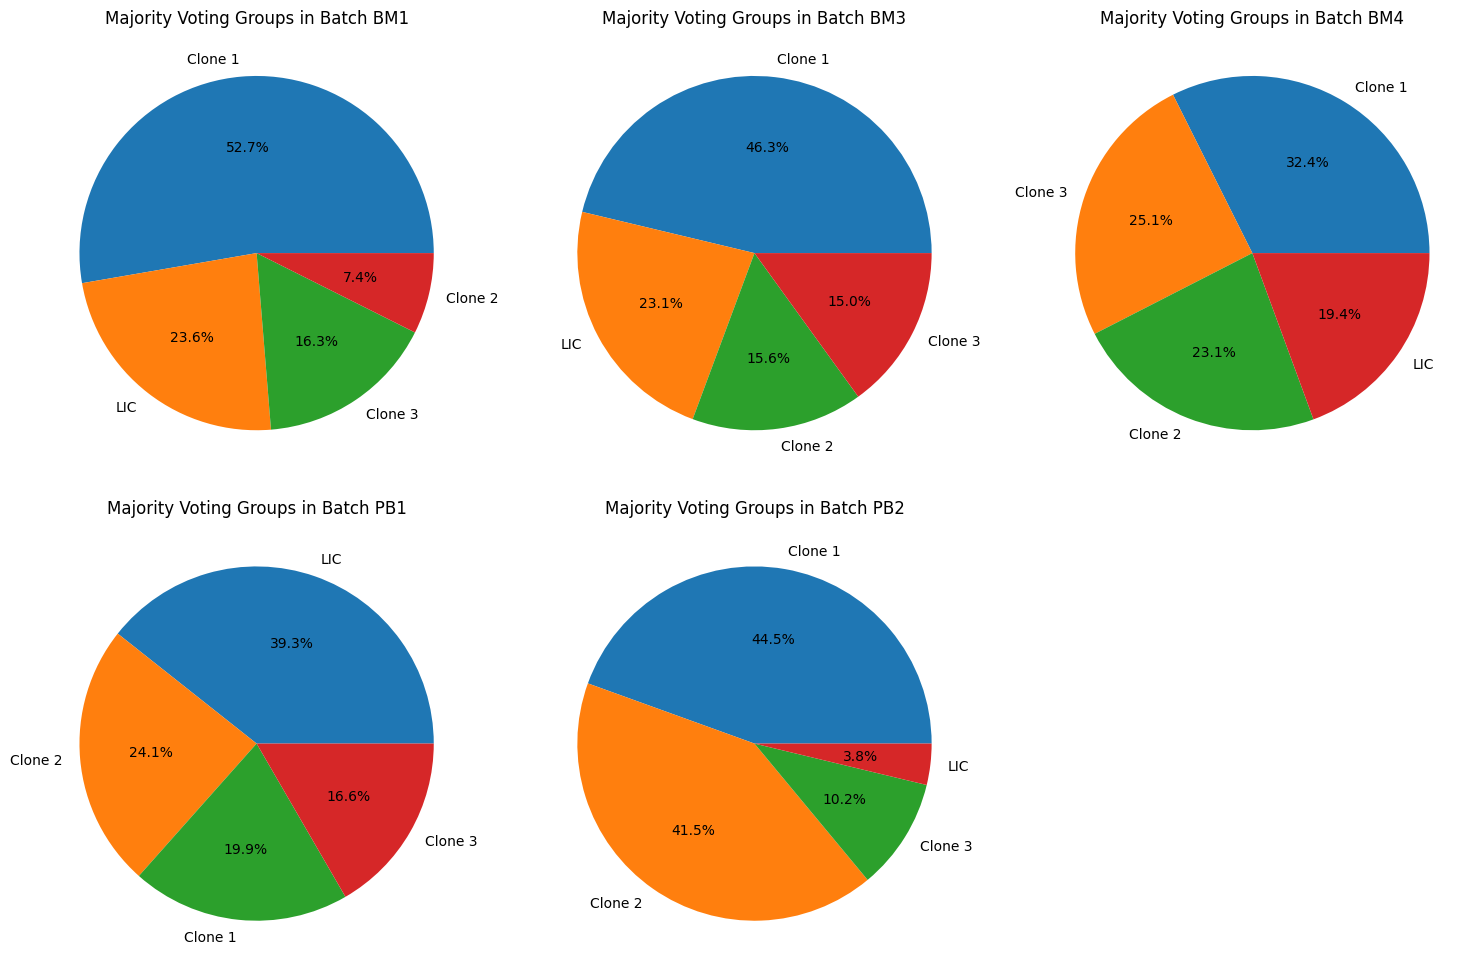

In [ ]:
# Pie charts of majority voting per batch #### Assuming 'adata' is your AnnData object and 'majority_voting' and 'batch' are your categories

batches = mdata.mod['rna'].obs['batch'].unique()

# Calculate the number of rows needed for the subplots

n_rows = int(np.ceil(len(batches) / 3))

# Create a figure and axes with subplots

fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*5))

# Flatten the axes array

axs = axs.flatten()

for i, batch in enumerate(batches):
    batch_data = mdata.mod['rna'][mdata.mod['rna'].obs['batch'] == batch]
    
    # Get the counts for each majority_voting group

    group_counts = batch_data.obs['majority_voting'].value_counts()
    
    # Create the pie chart on the appropriate subplot

    axs[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%')
    axs[i].set_title(f'Majority Voting Groups in Batch {batch}')

# Remove unused subplots

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
# Clean up the MuData object by deleting 'protein_names' from uns

del mdata.mod['rna'].uns['protein_names']
del mdata.mod['rna_subset'].uns['protein_names']

In [ ]:
### Model Testing ###
# Load the MuData MRD Test object
mrd_test = muon.read('/home/MRD_Test')

In [ ]:
# Score genes on the MRD test data

sc.tl.score_genes(mrd_test, gene_list=selected_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='score', random_state=0, copy=False, use_raw=None)

In [ ]:
# Run Leiden clustering on the MRD test data

sc.tl.leiden(mrd_test, resolution= 0.6 ,key_added="leiden_scVI")

In [ ]:
# Run celltypist.annotate() function on the MRD test data without overclustering labels

predictions3 = celltypist.annotate(
    mrd_test,
    model=new_model,
    majority_voting=True,
    #over_clustering='leiden_scVI'
)

# Convert predictions to AnnData object

mrd_test = predictions3.to_adata()

🔬 Input data has 23822 cells and 2364 genes
🔗 Matching reference genes in the model
🧬 861 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


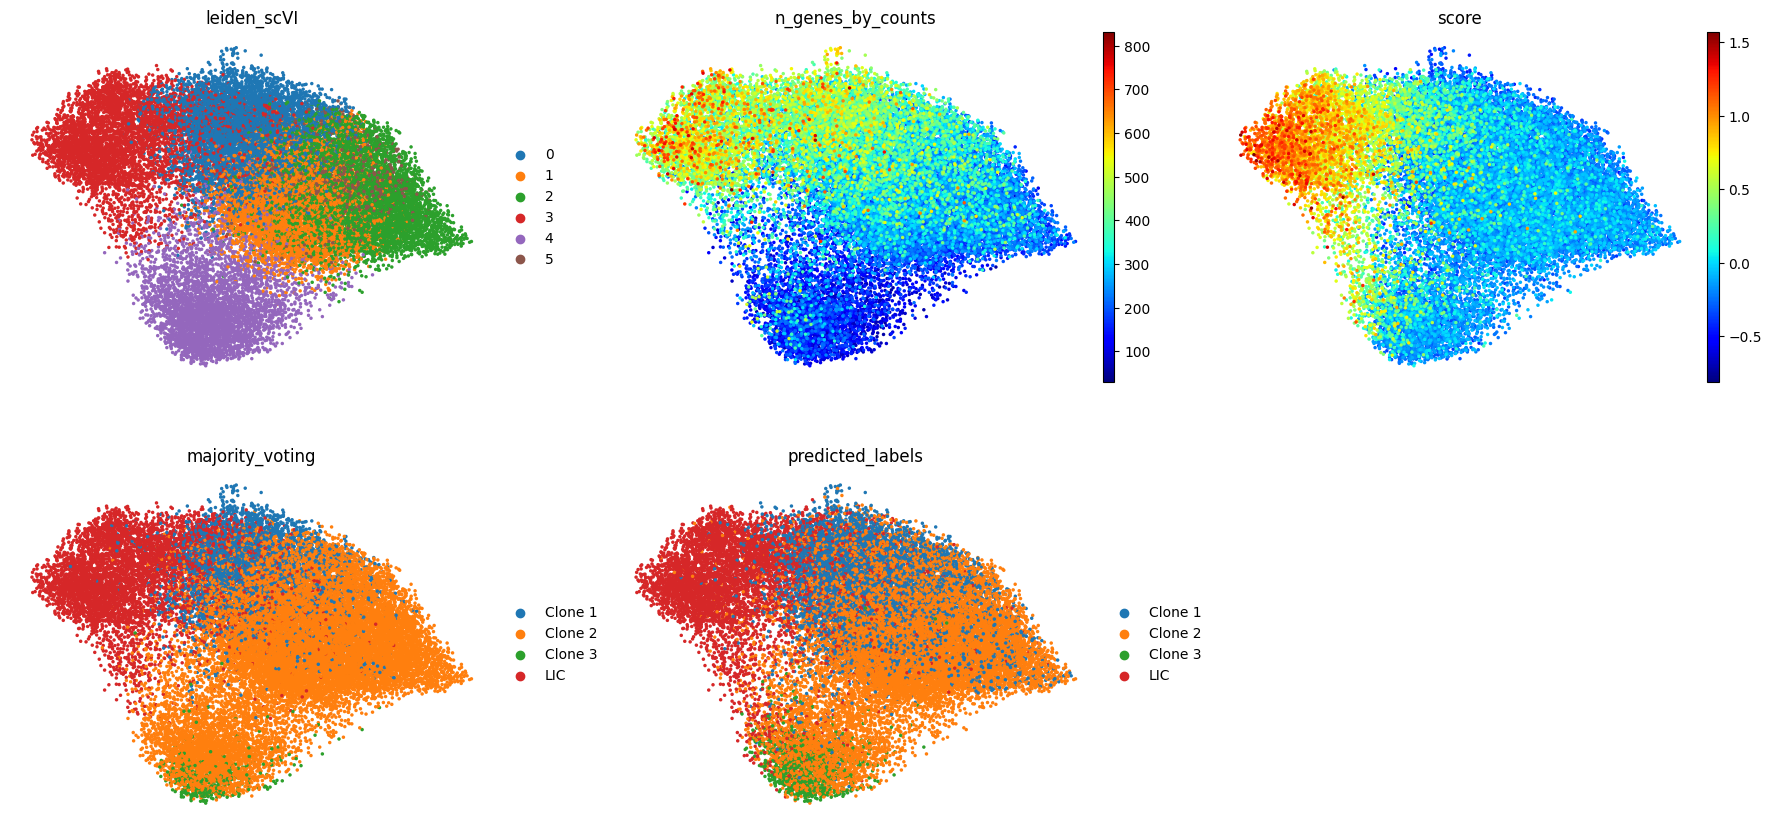

In [ ]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    mrd_test,
    basis="draw_graph_fa",
    color=['leiden_scVI','n_genes_by_counts','score','majority_voting','predicted_labels'],
    frameon=False,
    size=25,
    color_map="jet",
    ncols=3,
)

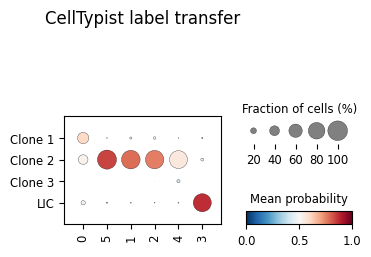

In [ ]:
# Dotplot of CellTypist predictions vs FA leiden_totalVI clusters

celltypist.dotplot(predictions3, use_as_reference = 'leiden_scVI', use_as_prediction = 'majority_voting')

In [ ]:
# Run celltypist.annotate() function on the MRD test data with overclustering labels

predictions4 = celltypist.annotate(
    mrd_test,
    model=new_model,
    majority_voting=True,
    over_clustering='leiden_scVI'
)

# Convert predictions to AnnData object

mrd_test = predictions4.to_adata()

🔬 Input data has 23822 cells and 2364 genes
🔗 Matching reference genes in the model
🧬 861 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


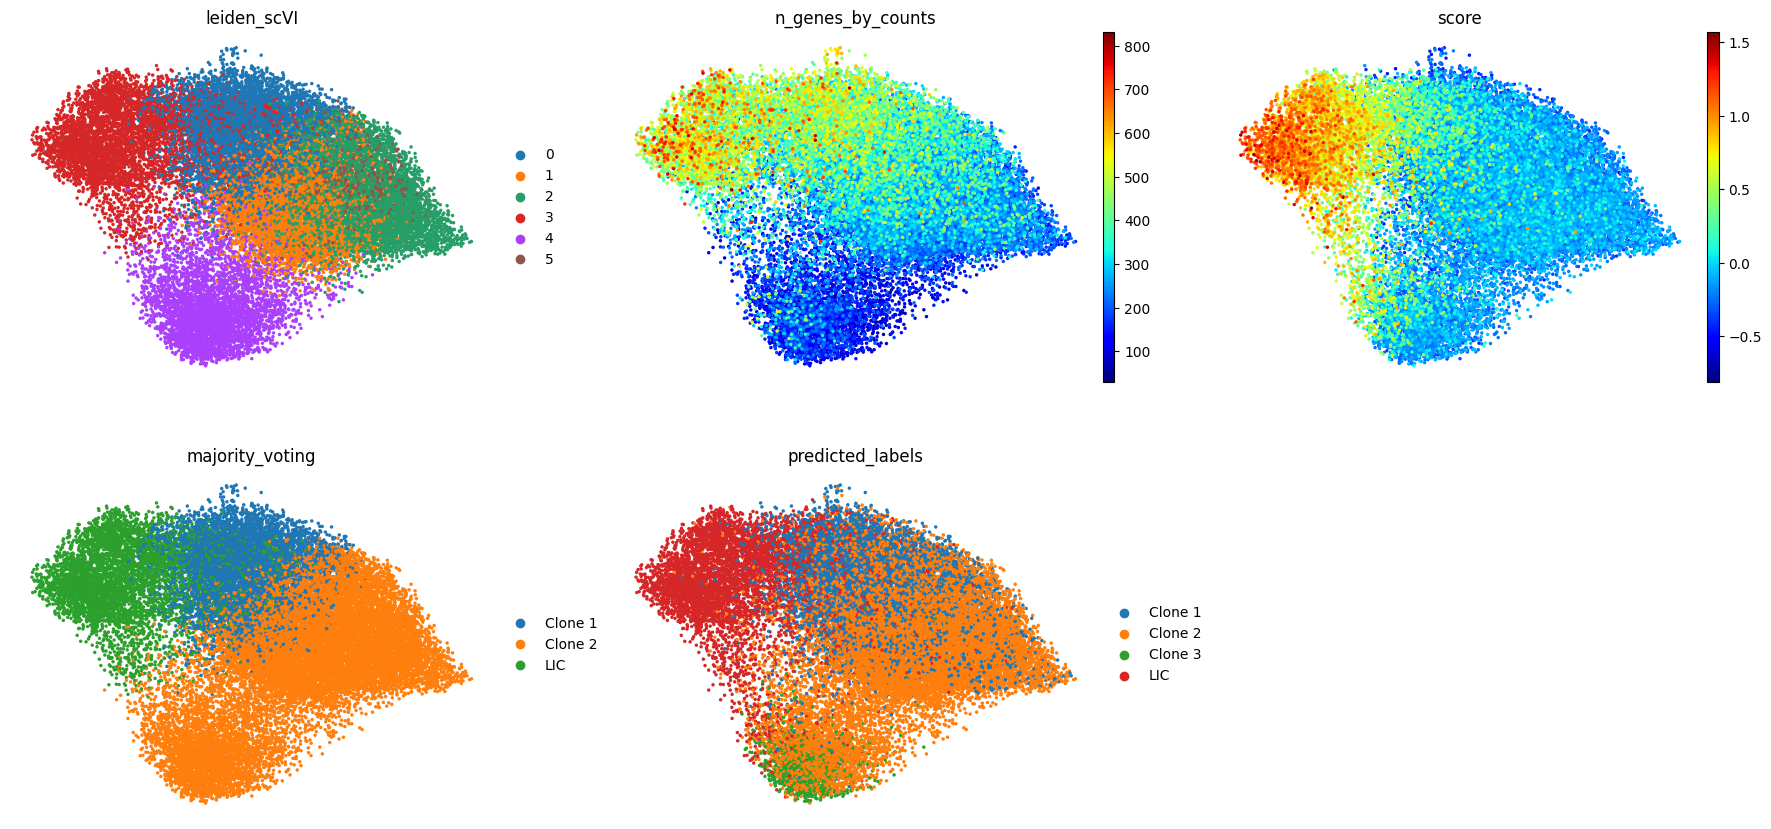

In [ ]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    mrd_test,
    basis="draw_graph_fa",
    color=['leiden_scVI','n_genes_by_counts','score','majority_voting','predicted_labels'],
    frameon=False,
    size=25,
    color_map="jet",
    ncols=3,
)

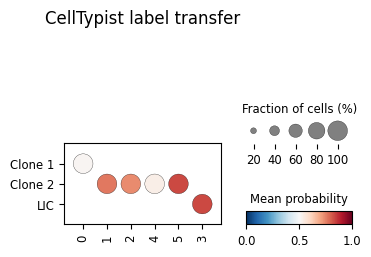

In [ ]:
# Dotplot of CellTypist predictions vs FA leiden_totalVI clusters

celltypist.dotplot(predictions4, use_as_reference = 'leiden_scVI', use_as_prediction = 'majority_voting')

In [ ]:
# Extract majority voting labels and batch information for downstream analysis

mrd_labels = mrd_test.obs[['majority_voting']].copy()
mrd_labels['batch'] = mrd_test.obs['batch'].copy()

In [16]:
mrd_labels

majority_voting     batch
AAACCTGCACTCGACG-1-mrd1Dx           Clone 2    mrd1Dx
AAACCTGCAGACACTT-1-mrd1Dx           Clone 1    mrd1Dx
AAACCTGGTTGAGGTG-1-mrd1Dx           Clone 2    mrd1Dx
AAACCTGTCAAGGTAA-1-mrd1Dx               LIC    mrd1Dx
AAACCTGTCCGCATAA-1-mrd1Dx           Clone 1    mrd1Dx
...                                     ...       ...
TGGCGCACATCTATGG-1-mrd11Rel         Clone 2  mrd11Rel
TGGGAAGGTTCAGTAC-1-mrd11Rel             LIC  mrd11Rel
TGGTTAGAGTGTACCT-1-mrd11Rel             LIC  mrd11Rel
TTCGAAGCAAGTCTGT-1-mrd11Rel         Clone 2  mrd11Rel
TTGCGTCCAAGAAAGG-1-mrd11Rel         Clone 2  mrd11Rel

[23822 rows x 2 columns]

In [ ]:
mrd_test

AnnData object with n_obs × n_vars = 23822 × 2364
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'draw_graph', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'umap', 'majority_voting_colors', 'predicted_labels_colors'
    obsm: 'X_draw_graph_fa', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
# Also extract the leiden_scVI clusters as 'Labels' for downstream analysis

mrd_test.obs['Labels'] = mrd_test.obs['leiden_scVI'].copy()

In [ ]:
### Modify 'Labels' to rename specific clusters and filter data ###

# Assuming 'adata' is your AnnData object
clusters = ['3']

# Assuming 'adata' is your AnnData objectfeature_selection=True ,top_genes=20
mrd_test.obs['Labels'] = mrd_test.obs['Labels'].cat.add_categories('LIC')

# Create a mask for the rows where 'leiden_scVI' is in the specified clusters
mask = mrd_test.obs['Labels'].isin(clusters)

# Apply the mask and rename the 'majority_voting' labels for these rows to 'blasts'
mrd_test.obs.loc[mask, 'Labels'] = 'LIC'

# Define the categories to remove
categories_to_remove = ['3']

# Filter the data
mrd_test = mrd_test[~mrd_test.obs['Labels'].isin(categories_to_remove)]


In [ ]:
# Assuming 'adata' is your AnnData object
clusters = ['0','1','2','4','5']

# Assuming 'adata' is your AnnData objectfeature_selection=True ,top_genes=20
mrd_test.obs['Labels'] = mrd_test.obs['Labels'].cat.add_categories('Blast')

# Create a mask for the rows where 'leiden_scVI' is in the specified clusters
mask = mrd_test.obs['Labels'].isin(clusters)

# Apply the mask and rename the 'majority_voting' labels for these rows to 'blasts'
mrd_test.obs.loc[mask, 'Labels'] = 'Blast'

# Define the categories to remove
categories_to_remove = ['0','1','2','4','5']

# Filter the data
mrd_test = mrd_test[~mrd_test.obs['Labels'].isin(categories_to_remove)]


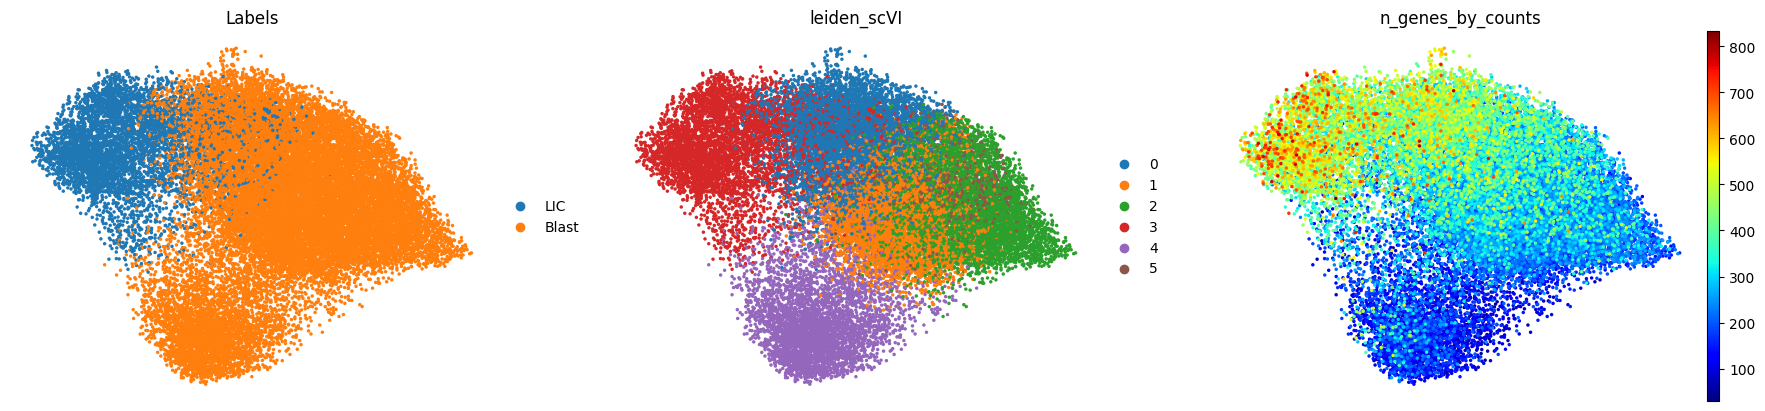

In [ ]:
# Plot the FA leiden_totalVI clusters

muon.pl.embedding(
    mrd_test,
    basis="draw_graph_fa",
    color=['Labels','leiden_scVI','n_genes_by_counts'],
    frameon=False,
    size=25,
    color_map="jet",
    ncols=3,
)

In [ ]:
STOP